## v3 : 외부데이터 통합 파일 생성
## v4 : 베이스 모델 생성
    - random_state 200 / 1 fold 만 학습
   
## V5~8 : 베이스 모델 학습 2
    - 5 kfold로 학습
    - 4월까지의 더미 데이터 생성 후, 7월 예측치까지 생성
        1. 특정 업종이 전체 월별로 데이터가 존재하지 않아 shift(3) 연산에서 문제가 발생 
        
    - submission 2( notebook ver 8)
        * 3개월전 값이 없는 데이터는 학습에서 제외
        * 6 kfold로 학습
        * amt와 lag_3 모두 log 변환
        
        
## V9 ~ 10 : 클러스터링 변수 추가
    - submission 3
    - 데이터셋 생성시 모든 기간에 존재하지 않는 데이터를 제거하는 것을 고민
        1. 전체가 8개 이하이며, 2020년을 맞출 수 있는 데이터가 모두 존재하지 않는 데이터는 삭제
        2. temp에서 사용한 학습 데이터가 더 성능이 좋다?
        
## V11 ~ 12
    - submission 5
        1. 클러스터링 제외
        2. 전체가 8개 이하이며, 2020년을 맞출 수 있는 데이터가 모두 존재하지 않는 데이터는 삭제
        3. Target이 -99인 값 제거(3달전 데이터는 있지만, 해당 월의 AMT가 존재하지 않는 rows)
        
## V13:
    - submission 6
        1. 클러스터링 관련 변수 추가

In [1]:
sub_ver = 6

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import gc

import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.metrics import mean_squared_error

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [3]:
# 한글 폰트 설치
!git clone https://github.com/namepen/nanum_font.git

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

font_dirs = ['nanum_font', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

mpl.rcParams['font.family'] = 'NanumGothic'

Cloning into 'nanum_font'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 23 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), done.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  if __name__ == '__main__':


## Load dataset

In [4]:
df = pd.read_csv('../input/dacon-jeju/201901-202003.csv')
sub = pd.read_csv('../input/dacon-jeju/submission.csv')

In [5]:
df.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


In [6]:
# str -> int categorical features
sido_dict = {sido: num for num, sido in enumerate(df['CARD_SIDO_NM'].unique())}
ccg_dict = {ccg: num for num, ccg in enumerate(df['CARD_CCG_NM'].unique())}
clss_dict = {clss: num for num, clss in enumerate(df['STD_CLSS_NM'].unique())}
age_dict = {age: num for num, age in enumerate(df['AGE'].unique())}

def preprocess_df(df):
    # Mapping
    df['CARD_SIDO_NM'] = df['CARD_SIDO_NM'].map(sido_dict).astype('int16')
    df['CARD_CCG_NM'] = df['CARD_CCG_NM'].map(ccg_dict).astype('int16')
    df['HOM_SIDO_NM'] = df['HOM_SIDO_NM'].map(sido_dict).astype('int16')
    df['HOM_CCG_NM'] = df['HOM_CCG_NM'].map(ccg_dict).astype('int16')
    df['STD_CLSS_NM'] = df['STD_CLSS_NM'].map(clss_dict).astype('int16')
    df['AGE'] = df['AGE'].map(age_dict).astype('int16')

    # True or False
    df['SEX_CTGO_CD'] = df['SEX_CTGO_CD'] == 1

    # Float to int
    df['CSTMR_CNT'] = df['CSTMR_CNT'].astype(int)
    df['AMT'] = df['AMT'].astype(int)
    df['FLC'] = df['FLC'].astype('int16')
    df['CNT'] = df['CNT'].astype('int16')

    # 날짜 변경
    df['REG_YYMM'] = pd.to_datetime(df['REG_YYMM'], format='%Y%m')
    return df

In [7]:
df = preprocess_df(df)

## Load external data

In [8]:
def external_data():
    # 외부 데이터 통합
    ex_df = pd.read_csv('../input/dacon-jeju/external_dataset.csv')
    ex_df.drop(columns=ex_df.columns[0], inplace=True)

    # 한글 column명 변경  
    ex_col = {col:f'ex_{num}' for num, col in enumerate(ex_df.columns[2:])}
    ex_df.rename(columns={'지역':'CARD_SIDO_NM'}, inplace=True)
    ex_df.rename(columns=ex_col, inplace = True)

    # REG_YYMM 날짜 type 변경
    ex_df['REG_YYMM'] = pd.to_datetime(ex_df['REG_YYMM'], format='%Y%m')

    # int categorical features로 변경
    ex_df['CARD_SIDO_NM'] = ex_df['CARD_SIDO_NM'].map(sido_dict)
    ex_df.drop(ex_df.loc[ex_df['CARD_SIDO_NM'].isnull()].index, inplace=True) # 전국으로 집계된 데이터 제외
    ex_df['CARD_SIDO_NM'] = ex_df['CARD_SIDO_NM'].astype(int)
    
    for col in ex_df.columns:
        if ex_df[col].dtype == 'float64':
            ex_df[col] = ex_df[col].astype('float32')
        if ex_df[col].dtype == 'int64':
            ex_df[col] = ex_df[col].astype('int32')
    
    
    # ex_col취업자증감 시도 type 변경
    ex_df.loc[ex_df['ex_1'] == '-', 'ex_1'] = '0'
    ex_df['ex_1'] = ex_df['ex_1'].astype(float)

    # 백화점판매액 시도 데이터 수정(null 값 -> -9999)
    ex_df.loc[ex_df['ex_3'] == '-', 'ex_3'] = -9999
    ex_df.loc[ex_df['ex_3'].isnull(), 'ex_3'] = -9999
    ex_df['ex_3'] = ex_df['ex_3'].astype(int)
    ex_df.loc[ex_df['ex_3'] <= 0, 'ex_3'] = -9999
    return ex_df

In [9]:
ex_df = external_data()
ex_df.head()

,REG_YYMM,CARD_SIDO_NM,ex_0,ex_1,ex_2,ex_3,ex_4,ex_5,ex_6,ex_7,...,ex_74,ex_75,ex_76,ex_77,ex_78,ex_79,ex_80,ex_81,ex_82,ex_83
0,2017-01-01,0,717,23.8,91878,-9999,94.199997,102.480003,102.919998,106.059998,...,101.010002,101.940002,100.510002,100.089996,103.099998,102.230003,104.239998,106.940002,86.699997,0.7
1,2017-01-01,1,6705,156.7,1447953,514371,105.300003,102.680000,102.970001,105.900002,...,100.779999,102.129997,101.610001,99.980003,102.639999,102.150002,103.419998,106.300003,103.800003,7.9
2,2017-01-01,2,1732,25.2,250562,82926,94.599998,102.519997,102.889999,105.989998,...,100.080002,102.050003,100.910004,100.000000,102.690002,101.660004,103.839996,106.199997,91.500000,-4.3
3,2017-01-01,3,1436,1.5,140492,-9999,89.699997,102.360001,102.559998,105.660004,...,100.449997,102.230003,100.760002,100.050003,103.080002,102.360001,103.180000,106.230003,88.900002,-11.3
4,2017-01-01,4,747,10.9,151921,74748,89.900002,102.769997,103.089996,106.059998,...,100.910004,101.779999,101.440002,99.989998,102.330002,101.419998,104.209999,107.839996,87.500000,1.2


## 지역/ 업종별 클러스터링 

In [10]:
clust_df = pd.read_csv('../input/dacon-jeju/SIDO_STD.csv')

clust_df['CARD_SIDO_NM'] = clust_df['CARD_SIDO_NM'].map(sido_dict).astype(int)
clust_df['STD_CLSS_NM'] = clust_df['STD_CLSS_NM'].map(clss_dict).astype(int)

In [11]:
clust_df.head()

,CARD_SIDO_NM,STD_CLSS_NM,SIDO_STD
0,0,0,268
1,0,1,309
2,0,2,276
3,0,3,213
4,0,39,31


In [12]:
df.sum()

CARD_SIDO_NM         160882227
CARD_CCG_NM         2711045865
STD_CLSS_NM          483798575
HOM_SIDO_NM          148139741
HOM_CCG_NM          2581042648
AGE                   47218300
SEX_CTGO_CD           14506378
FLC                   69263195
CSTMR_CNT           1530486337
AMT             60296027049006
CNT                 2886474566
dtype: int64

## 지역 / 월별 사용량 합산

In [13]:
# AMT를 날짜별 / 지역별 합산한다
df_sum = df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index()
df_sum['REG_YYMM'] = pd.to_datetime(df_sum['REG_YYMM'], format='%Y%m')

총 53개의 지역별 업종에서 전체 기간의 데이터가 존재하지 않는다.

In [14]:
len_df = df_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM']).apply(len).reset_index()
print(len(len_df.loc[len_df[0] != 15]))
len_20 = df_sum.loc[(df_sum['REG_YYMM'] < '2020-01-01')&(df_sum['REG_YYMM'] >= '2019-10-01')].groupby(['CARD_SIDO_NM', 'STD_CLSS_NM']).apply(len).reset_index()

# 전체 데이터가 8개 미만이면서 2020년 데이터를 예측할때 사용할 데이터를 모두 보유하고 있지 않은 데이터는 삭제한다.
len_del = len_df.loc[len_df[0] < 8]
len_del = len_del.merge(len_20, on=['CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
len_del.fillna(0, inplace=True)
len_del = len_del.loc[len_del['0_y'] < 3]

53


In [15]:
len_del

,CARD_SIDO_NM,STD_CLSS_NM,0_x,0_y
0,0,34,5,0.0
1,0,39,1,0.0
2,1,39,4,0.0
3,3,39,5,0.0
4,6,32,1,0.0
5,9,4,1,0.0
6,9,37,1,0.0
7,9,39,1,0.0
8,10,36,3,2.0
9,10,39,2,0.0


In [16]:
for sido, clss in zip(len_del['CARD_SIDO_NM'], len_del['STD_CLSS_NM']):
    df_sum.drop(df_sum.loc[(df_sum['CARD_SIDO_NM'] == sido)&(df_sum['STD_CLSS_NM'] == clss)].index, inplace=True)

In [17]:
df_sum.loc[(df_sum['CARD_SIDO_NM'] == sido_dict['강원'])&(df_sum['STD_CLSS_NM'] == clss_dict['면세점'])]

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT


In [18]:
df_sum.loc[(df_sum['CARD_SIDO_NM'] == sido_dict['강원'])&( df_sum['STD_CLSS_NM'] == clss_dict['과실 및 채소 소매업'])]

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
2,2019-01-01,0,2,1286979106
633,2019-02-01,0,2,1116265883
1260,2019-03-01,0,2,939227950
1890,2019-04-01,0,2,827683360
2523,2019-05-01,0,2,1021472585
3160,2019-06-01,0,2,1001626059
3792,2019-07-01,0,2,953346915
4431,2019-08-01,0,2,1384944417
5063,2019-09-01,0,2,1313429320
5690,2019-10-01,0,2,1317877211


In [19]:
def add_empty_months(df_sum):
    base_df = df_sum.loc[(df_sum['CARD_SIDO_NM'] == 0)&( df_sum['STD_CLSS_NM'] == 0)].reset_index(drop=True)
    base_df.drop(columns = 'AMT', inplace=True)
    
    for sido, clss in zip(len_df['CARD_SIDO_NM'], len_df['STD_CLSS_NM']):
        temp = df_sum.loc[(df_sum['CARD_SIDO_NM'] == sido)&( df_sum['STD_CLSS_NM'] == clss)]
        temp_idx = temp.index

        temp = temp.merge(base_df['REG_YYMM'], on='REG_YYMM', how='right')
        temp['CARD_SIDO_NM'] = sido
        temp['STD_CLSS_NM'] = clss
        temp.fillna(-99, inplace=True) # -99로 설정해서 추후에 학습 데이터에서 해당 값을 제거 여부 판단하기(-99를 그냥 0으로 처리 or 학습에서 제외하기)
        temp = temp.reset_index(drop=True).sort_values('REG_YYMM')

        df_sum.drop(temp_idx, inplace=True)
        df_sum = pd.concat([df_sum.reset_index(drop=True), temp], axis=0)
    return df_sum

In [20]:
df_sum = add_empty_months(df_sum)

In [21]:
# Check data
df_sum.loc[(df_sum['CARD_SIDO_NM'] == sido_dict['강원'])&( df_sum['STD_CLSS_NM'] == clss_dict['면세점'])]

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
477,2019-02-01,0,34,-99.0
478,2019-03-01,0,34,-99.0
479,2019-04-01,0,34,-99.0
480,2019-05-01,0,34,-99.0
481,2019-06-01,0,34,-99.0
482,2019-07-01,0,34,-99.0
483,2019-08-01,0,34,-99.0
484,2019-09-01,0,34,-99.0
485,2019-10-01,0,34,-99.0
486,2019-11-01,0,34,-99.0


In [22]:
# 추가 월별 데이터를 추가한다.
for day in ['2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01']:
    add_df =  df_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM']).first().reset_index().copy()
    add_df['REG_YYMM'] = pd.to_datetime(day)
    add_df['AMT'] = 0
    df_sum = pd.concat([df_sum, add_df], axis=0).reset_index(drop=True)
    del add_df
df_sum = df_sum.sort_values(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])

In [23]:
# 세달 전 매출액
df_sum['lag_3'] = df_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].shift(3)

# 일년 전 매출액
#df_sum['lag_12'] = df_sum.groupby('CARD_SIDO_NM')['AMT'].shift(12)

# 날짜도 변경
df_sum['REG_YYMM'] = df_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])['REG_YYMM'].shift(3)

# 훈련할 수 없는 19년 1,2,3 월 데이터 제거
df_sum = df_sum.dropna().reset_index(drop=True)

In [24]:
df_sum.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT,lag_3
0,2019-01-01,0,33,3098900.0,811000.0
1,2019-01-01,0,38,2530000.0,434000.0
2,2019-01-01,1,37,71345340.0,70583518.0
3,2019-01-01,1,38,1156500.0,-99.0
4,2019-01-01,3,33,1079000.0,1367000.0


In [25]:
#df_sum.loc[(df_sum['CARD_SIDO_NM'] == 9 )&( df_sum['STD_CLSS_NM'] == 3)]
df_sum.loc[(df_sum['CARD_SIDO_NM'] == sido_dict['강원'])&( df_sum['STD_CLSS_NM'] == clss_dict['면세점'])]

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT,lag_3
60,2019-02-01,0,34,-99.0,-99.0
705,2019-03-01,0,34,-99.0,-99.0
1351,2019-04-01,0,34,-99.0,-99.0
1996,2019-05-01,0,34,-99.0,-99.0
2642,2019-06-01,0,34,-99.0,-99.0
3287,2019-07-01,0,34,-99.0,-99.0
3935,2019-08-01,0,34,-99.0,-99.0
4579,2019-09-01,0,34,-99.0,-99.0
5227,2019-10-01,0,34,-99.0,-99.0
5873,2019-11-01,0,34,-99.0,-99.0


## 지역/월별 AMT 데이터셋

In [26]:
# one functions code
def add_empty_months(df_sum):
    base_df = df_sum.loc[(df_sum['CARD_SIDO_NM'] == 0)&( df_sum['STD_CLSS_NM'] == 0)].reset_index(drop=True)
    base_df.drop(columns = 'AMT', inplace=True)
    
    for sido, clss in zip(len_df['CARD_SIDO_NM'], len_df['STD_CLSS_NM']):
        temp = df_sum.loc[(df_sum['CARD_SIDO_NM'] == sido)&( df_sum['STD_CLSS_NM'] == clss)]
        temp_idx = temp.index

        temp = temp.merge(base_df['REG_YYMM'], on='REG_YYMM', how='right')
        temp['CARD_SIDO_NM'] = sido
        temp['STD_CLSS_NM'] = clss
        temp.fillna(-99, inplace=True) # -99로 설정해서 추후에 학습 데이터에서 해당 값을 제거 여부 판단하기(-99를 그냥 0으로 처리 or 학습에서 제외하기)
        temp = temp.reset_index(drop=True).sort_values('REG_YYMM')

        df_sum.drop(temp_idx, inplace=True)
        df_sum = pd.concat([df_sum.reset_index(drop=True), temp], axis=0)
    return df_sum

def data_sum(df, is_add=True):
    # AMT를 날짜별 / 지역별 합산한다
    df_sum = df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index()
    df_sum['REG_YYMM'] = pd.to_datetime(df_sum['REG_YYMM'], format='%Y%m')
    
    for sido, clss in zip(len_del['CARD_SIDO_NM'], len_del['STD_CLSS_NM']):
        df_sum.drop(df_sum.loc[(df_sum['CARD_SIDO_NM'] == sido)&(df_sum['STD_CLSS_NM'] == clss)].index, inplace=True)
    
    if is_add:
        df_sum = add_empty_months(df_sum)
    
    # 테스트할 월별 데이터를 추가한다.
    for day in ['2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01']:
        add_df =  df_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM']).first().reset_index().copy()
        add_df['REG_YYMM'] = pd.to_datetime(day)
        add_df['AMT'] = -99
        df_sum = pd.concat([df_sum, add_df], axis=0).reset_index(drop=True)
        del add_df
    df_sum = df_sum.sort_values(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])
    
    ###### Add Featrues ######
    # 세달 전 매출액
    df_sum['lag_3'] = df_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].shift(3)
    # 일년 전 매출액
    #df_sum['lag_12'] = df_sum.groupby('CARD_SIDO_NM')['AMT'].shift(12)
    # 날짜도 변경
    df_sum['REG_YYMM'] = df_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])['REG_YYMM'].shift(3)
    # 훈련할 수 없는 19년 1,2,3 월 데이터 제거
    df_sum = df_sum.dropna().reset_index(drop=True)
    return df_sum

## Modeling

In [27]:
# make lgb dataset

In [28]:
### Concat df and ex_df
df_sum = data_sum(df, is_add=False)

# 외부 데이터 변수 추가
df_sum = df_sum.merge(ex_df, on=['REG_YYMM', 'CARD_SIDO_NM'], how='left')

# 월 추가
df_sum['month'] = df_sum['REG_YYMM'].dt.month

# 클러스터 변수 추가
df_sum = df_sum.merge(clust_df, on=['CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')

In [29]:
df_sum.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT,lag_3,ex_0,ex_1,ex_2,ex_3,ex_4,...,ex_76,ex_77,ex_78,ex_79,ex_80,ex_81,ex_82,ex_83,month,SIDO_STD
0,2019-01-01,0,0,106548473,1.483547e+08,772,20.8,83366,-9999,108.099998,...,99.230003,98.410004,102.269997,104.279999,110.68,108.129997,101.400002,10.3,1,268
1,2019-01-01,0,1,3964893280,1.229200e+09,772,20.8,83366,-9999,108.099998,...,99.230003,98.410004,102.269997,104.279999,110.68,108.129997,101.400002,10.3,1,309
2,2019-01-01,0,2,827683360,1.286979e+09,772,20.8,83366,-9999,108.099998,...,99.230003,98.410004,102.269997,104.279999,110.68,108.129997,101.400002,10.3,1,276
3,2019-01-01,0,3,17905610,3.065677e+07,772,20.8,83366,-9999,108.099998,...,99.230003,98.410004,102.269997,104.279999,110.68,108.129997,101.400002,10.3,1,213
4,2019-01-01,0,4,5904100,1.310150e+07,772,20.8,83366,-9999,108.099998,...,99.230003,98.410004,102.269997,104.279999,110.68,108.129997,101.400002,10.3,1,167


In [30]:
def model_dataset(df_sum):
    # Define columns
    categorical_features = ['month', 'CARD_SIDO_NM', 'STD_CLSS_NM']
    train_columns = df_sum.columns[1:][df_sum.columns[1:] != 'AMT']

    train_data = df_sum.loc[df_sum['REG_YYMM'] <= '2019-12-31'].reset_index(drop=True)
    test_data = df_sum.loc[df_sum['REG_YYMM'] > '2019-12-31'].reset_index(drop=True)

    train_data.drop(train_data.loc[train_data['lag_3'] == -99].index, inplace=True)
    #train_data.loc[train_data['AMT'] == -99, 'AMT'] = 0
    train_data.drop(train_data.loc[train_data['AMT'] == -99, 'AMT'].index, inplace=True)

    # AMT를 로그 변환 & lag_3도 변환
    #train_data['lag_3'] = np.log1p(train_data['lag_3'])
    
    print(f"Total columns : {len(train_columns)} / ({list(train_columns[:10])})")
    print(f"Train data : {len(train_data)} / Test data : {len(test_data)}")
    return categorical_features, train_columns, train_data, test_data

In [31]:
categorical_features, train_columns, train_data, test_data = model_dataset(df_sum)

Total columns : 89 / (['CARD_SIDO_NM', 'STD_CLSS_NM', 'lag_3', 'ex_0', 'ex_1', 'ex_2', 'ex_3', 'ex_4', 'ex_5', 'ex_6'])
Train data : 7488 / Test data : 2488


In [32]:
def run_lgb():
    params = {'verbose': 100,
              'learning_rate': 0.015,
              'metric': 'rmse',
              #'bagging_freq': 3
              'boosting_type': 'gbdt',
              'eval_metric': 'rmse',
              'objective': 'tweedie',
              'tweedie_variance_power': 1.1,
              'n_jobs': -1,
             #'objective': 'regression',
              'seed': 42}
    oof_pred = np.zeros(shape=(len(train_data)))
    y_pred = np.zeros(shape=(len(test_data)))

    features = pd.DataFrame()

    kf = KFold(n_splits=6, shuffle=True, random_state=220)

    for num, (tr_idx, val_idx) in enumerate(kf.split(train_data)):
        print('=' * 50)
        print(f'{num+1} fold Train')
        lgb_train = lgb.Dataset(train_data[train_columns].iloc[tr_idx], np.log1p(train_data['AMT'].iloc[tr_idx]), 
                                categorical_feature=categorical_features)
        lgb_valid = lgb.Dataset(train_data[train_columns].iloc[val_idx], np.log1p(train_data['AMT'].iloc[val_idx]), 
                              categorical_feature=categorical_features)

        model = lgb.train(params, lgb_train, num_boost_round = 100000, early_stopping_rounds = 200, 
                                 valid_sets = [lgb_train, lgb_valid], verbose_eval = 500)

        oof_pred[val_idx] = model.predict(train_data[train_columns].iloc[val_idx])
        y_pred += model.predict(test_data[train_columns]) / 6 
        features[f'importance_{num}'] = model.feature_importance()

    print('=' * 50)
    print(f"model oof_pred rmse error :{mean_squared_error(np.log1p(train_data['AMT']), oof_pred)**1/2}")
    print('=' * 50)

    features['importance'] = features[[col for col in features.columns if col.startswith('importance')]].mean(axis=1)
    features['columns'] = model.feature_name()
    return model, features, oof_pred, y_pred

In [33]:
model, features, oof_pred, y_pred = run_lgb()

1 fold Train
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[500]	training's rmse: 0.270732	valid_1's rmse: 0.411641
[1000]	training's rmse: 0.180798	valid_1's rmse: 0.38912
[1500]	training's rmse: 0.133187	valid_1's rmse: 0.381557
[2000]	training's rmse: 0.104988	valid_1's rmse: 0.378528
[2500]	training's rmse: 0.0858799	valid_1's rmse: 0.375898
[3000]	training's rmse: 0.0708236	valid_1's rmse: 0.374728
[3500]	training's rmse: 0.0590389	valid_1's rmse: 0.373769
[4000]	training's rmse: 0.0505255	valid_1's rmse: 0.372927
[4500]	training's rmse: 0.0433945	valid_1's rmse: 0.37214
[5000]	training's rmse: 0.0372829	valid_1's rmse: 0.371481
[5500]	training's rmse: 0.0323028	valid_1's rmse: 0.371131
[6000]	training's rmse: 0.027994	valid_1's rmse: 0.370785
[6500]	training's rmse: 0.0248262	valid_1's rmse: 0.370595
[7000]	training's rmse: 0.0218874	valid_1's rmse: 0.370387
[7500]	training's rmse: 0.0197809	valid_1's rmse: 0.370221
Early stopping, best iteration is:
[7538]	training's rmse: 0.0196197	valid_1's rmse: 0.370201
2 fold Train
Training until v

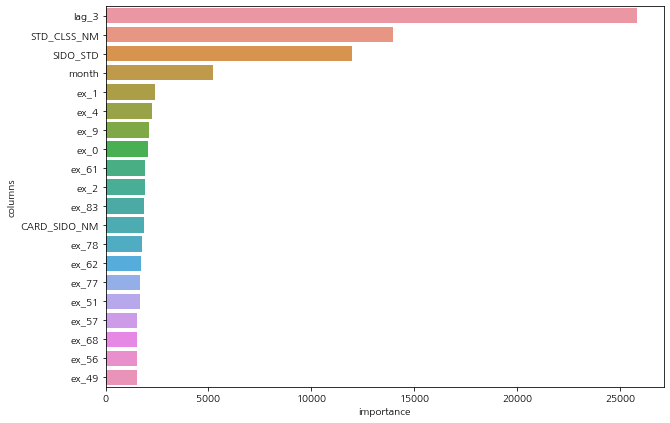

In [34]:
fig, ax= plt.subplots(1,1, figsize=(10, 7))
sns.barplot(x='importance', y='columns', data=features.sort_values('importance', ascending=False)[:20])
plt.show()

## 예측치 비교

In [35]:
train_data['pred'] = np.exp(oof_pred)
train_data['lag_3'] = np.exp(train_data['lag_3'])
train_data['error'] = abs(train_data['AMT'] - train_data['pred'])
train_data.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT,lag_3,ex_0,ex_1,ex_2,ex_3,ex_4,...,ex_78,ex_79,ex_80,ex_81,ex_82,ex_83,month,SIDO_STD,pred,error
0,2019-01-01,0,0,106548473,inf,772,20.8,83366,-9999,108.099998,...,102.269997,104.279999,110.68,108.129997,101.400002,10.3,1,268,1.056510e+08,8.974954e+05
1,2019-01-01,0,1,3964893280,inf,772,20.8,83366,-9999,108.099998,...,102.269997,104.279999,110.68,108.129997,101.400002,10.3,1,309,3.131690e+09,8.332034e+08
2,2019-01-01,0,2,827683360,inf,772,20.8,83366,-9999,108.099998,...,102.269997,104.279999,110.68,108.129997,101.400002,10.3,1,276,7.816057e+08,4.607763e+07
3,2019-01-01,0,3,17905610,inf,772,20.8,83366,-9999,108.099998,...,102.269997,104.279999,110.68,108.129997,101.400002,10.3,1,213,2.806141e+07,1.015580e+07
4,2019-01-01,0,4,5904100,inf,772,20.8,83366,-9999,108.099998,...,102.269997,104.279999,110.68,108.129997,101.400002,10.3,1,167,4.902881e+06,1.001219e+06


In [36]:
pred_sum = train_data.groupby(['REG_YYMM', 'CARD_SIDO_NM'])['AMT', 'pred'].sum().reset_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


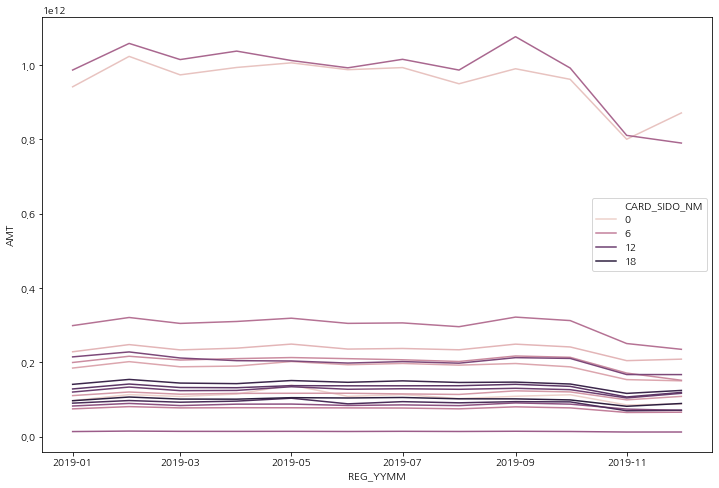

In [37]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='REG_YYMM', y='AMT', hue='CARD_SIDO_NM', data=pred_sum)
plt.show()

In [38]:
pred_sum = pd.melt(pred_sum, id_vars=['REG_YYMM', 'CARD_SIDO_NM'], value_vars=['AMT', 'pred'])

In [39]:
'''plt.figure(figsize=(12, 8))
sns.lineplot(x='REG_YYMM', y='value', hue='variable', data=pred_sum.loc[pred_sum['CARD_SIDO_NM'] == 6])
plt.show()'''

"plt.figure(figsize=(12, 8))\nsns.lineplot(x='REG_YYMM', y='value', hue='variable', data=pred_sum.loc[pred_sum['CARD_SIDO_NM'] == 6])\nplt.show()"

## Test predict

In [40]:
test_data['AMT'] =np.exp(y_pred)
test_data.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT,lag_3,ex_0,ex_1,ex_2,ex_3,ex_4,...,ex_76,ex_77,ex_78,ex_79,ex_80,ex_81,ex_82,ex_83,month,SIDO_STD
0,2020-01-01,0,0,1.109677e+08,1.850088e+08,789,13.6,93815,-9999,97.599998,...,104.849998,96.209999,102.949997,103.730003,113.080002,110.779999,90.5,-10.7,1,268
1,2020-01-01,0,1,1.662971e+09,1.241102e+09,789,13.6,93815,-9999,97.599998,...,104.849998,96.209999,102.949997,103.730003,113.080002,110.779999,90.5,-10.7,1,309
2,2020-01-01,0,2,1.200243e+09,1.576557e+09,789,13.6,93815,-9999,97.599998,...,104.849998,96.209999,102.949997,103.730003,113.080002,110.779999,90.5,-10.7,1,276
3,2020-01-01,0,3,1.262207e+07,3.015254e+07,789,13.6,93815,-9999,97.599998,...,104.849998,96.209999,102.949997,103.730003,113.080002,110.779999,90.5,-10.7,1,213
4,2020-01-01,0,4,2.609504e+06,4.625300e+06,789,13.6,93815,-9999,97.599998,...,104.849998,96.209999,102.949997,103.730003,113.080002,110.779999,90.5,-10.7,1,167


## Change test data

In [41]:
test_data['REG_YYMM'] = test_data['REG_YYMM'].dt.to_period('M').astype(str).str.replace('-', '')
test_data['REG_YYMM'] = test_data['REG_YYMM'].astype(int)
test_data['REG_YYMM'] += 3
test_data['CARD_SIDO_NM'] = test_data['CARD_SIDO_NM'].map(dict(map(reversed, sido_dict.items())))
test_data['STD_CLSS_NM'] = test_data['STD_CLSS_NM'].map(dict(map(reversed, clss_dict.items())))


In [42]:
test_data.loc[(test_data['CARD_SIDO_NM'] == '강원')&(test_data['STD_CLSS_NM'] == '건강보조식품 소매업')]

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT,lag_3,ex_0,ex_1,ex_2,ex_3,ex_4,...,ex_76,ex_77,ex_78,ex_79,ex_80,ex_81,ex_82,ex_83,month,SIDO_STD
0,202004,강원,건강보조식품 소매업,1.109677e+08,185008768.0,789,13.6,93815,-9999,97.599998,...,104.849998,96.209999,102.949997,103.730003,113.080002,110.779999,90.500000,-10.7,1,268
606,202005,강원,건강보조식품 소매업,6.197276e+07,76505561.0,797,27.9,73219,-9999,93.599998,...,104.900002,96.160004,101.639999,104.099998,112.790001,111.169998,87.800003,-1.3,2,268
1226,202006,강원,건강보조식품 소매업,7.201225e+07,96059012.0,829,-2.5,71575,-9999,105.900002,...,102.040001,96.110001,101.449997,104.050003,112.580002,111.290001,105.300003,5.9,3,268
1854,202007,강원,건강보조식품 소매업,8.907881e+05,-99.0,834,-30.2,74470,-9999,99.099998,...,98.889999,96.739998,101.470001,102.370003,112.820000,110.910004,99.500000,-8.7,4,268


In [43]:
sub2 = sub.copy()
sub2.drop(columns='AMT', inplace=True)

In [44]:
sub2 = sub2.merge(test_data[test_data.columns[:4]], on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')

#sub2.drop(columns='index', inplace=True)
sub2.fillna(0, inplace=True)

In [45]:
sub2

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,강원,건강보조식품 소매업,1.109677e+08
1,1,202004,강원,골프장 운영업,1.662971e+09
2,2,202004,강원,과실 및 채소 소매업,1.200243e+09
3,3,202004,강원,관광 민예품 및 선물용품 소매업,1.262207e+07
4,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00
...,...,...,...,...,...
1389,1389,202007,충북,피자 햄버거 샌드위치 및 유사 음식점업,9.461813e+05
1390,1390,202007,충북,한식 음식점업,1.002495e+06
1391,1391,202007,충북,호텔업,8.626349e+05
1392,1392,202007,충북,화장품 및 방향제 소매업,9.248175e+05


In [46]:
sub2.to_csv(f'submission_v{sub_ver}.csv', index=False)

In [47]:
# 글꼴 삭제
!rm -r nanum_font/

In [48]:
# 이후 세달동안의 평균 판매량 & 편차값

'''temp = df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index()
temp['REG_YYMM'] = pd.to_datetime(df_sum['REG_YYMM'], format='%Y%m')

print(len(temp))
temp.head()

temp['lag_3'] = temp.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].shift(3)#.apply(lambda x: x.rolling(3).mean()# if len(x) >=3 else x.mean())

temp.tail()

def custom_fc(data):
    try:
        return np.mean(data[:3].values)
    except:
        return -99

temp2 = temp[:1000]

temp2.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].rolling(4).apply(custom_fc)

#temp['rmean_3'] = temp['lag_3'].rolling(3).mean().round(0)
j = temp.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].rolling(4).apply(custom_fc)

temp

temp2['t'] = temp2['AMT'].rolling(4).apply(lambda x: x[:3].mean())

#temp.loc[(temp['CARD_SIDO_NM'] == 9 )&( temp['STD_CLSS_NM'] == 3)]
temp.loc[(temp['CARD_SIDO_NM'] == sido_dict['강원'])&( temp['STD_CLSS_NM'] == clss_dict['면세점'])]'''

"temp = df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index()\ntemp['REG_YYMM'] = pd.to_datetime(df_sum['REG_YYMM'], format='%Y%m')\n\nprint(len(temp))\ntemp.head()\n\ntemp['lag_3'] = temp.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].shift(3)#.apply(lambda x: x.rolling(3).mean()# if len(x) >=3 else x.mean())\n\ntemp.tail()\n\ndef custom_fc(data):\n    try:\n        return np.mean(data[:3].values)\n    except:\n        return -99\n\ntemp2 = temp[:1000]\n\ntemp2.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].rolling(4).apply(custom_fc)\n\n#temp['rmean_3'] = temp['lag_3'].rolling(3).mean().round(0)\nj = temp.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].rolling(4).apply(custom_fc)\n\ntemp\n\ntemp2['t'] = temp2['AMT'].rolling(4).apply(lambda x: x[:3].mean())\n\n#temp.loc[(temp['CARD_SIDO_NM'] == 9 )&( temp['STD_CLSS_NM'] == 3)]\ntemp.loc[(temp['CARD_SIDO_NM'] == sido_dict['강원'])&( temp['STD_CLSS_NM'] == clss_dict['면세점'])]"

In [49]:
'''merge_cols = ['CARD_SIDO_NM', 'STD_CLSS_NM']

# AMT를 날짜별 / 지역별 합산한다
df_sum = df.groupby(list(['REG_YYMM']) + merge_cols)['AMT'].sum().reset_index()
df_sum['REG_YYMM'] = pd.to_datetime(df_sum['REG_YYMM'], format='%Y%m')

for sido, clss in zip(len_del['CARD_SIDO_NM'], len_del['STD_CLSS_NM']):
        df_sum.drop(df_sum.loc[(df_sum['CARD_SIDO_NM'] == sido)&(df_sum['STD_CLSS_NM'] == clss)].index, inplace=True)

# 4월에 해당하는 데이터를 생성한다.
add_df =  df_sum.groupby(merge_cols).first().reset_index().copy()
add_df['REG_YYMM'] = pd.to_datetime('2020-04-01')
add_df['AMT'] = 0
df_sum = pd.concat([df_sum, add_df], axis=0).reset_index(drop=True)
df_sum = df_sum.sort_values('REG_YYMM')

# 세달 전 매출액
df_sum['lag_3'] = df_sum.groupby(merge_cols)['AMT'].shift(3)

# 날짜도 변경
df_sum['REG_YYMM'] = df_sum.groupby(merge_cols)['REG_YYMM'].shift(3)

# shift로 생성되지 않는 데이터는 삭제함.
df_sum = df_sum.dropna().reset_index(drop=True)

# 외부 데이터와 통합
df_sum = df_sum.merge(ex_df, on=['REG_YYMM', 'CARD_SIDO_NM'], how='left')

# 월 추가
df_sum['month'] = df_sum['REG_YYMM'].dt.month

# 외부 데이터 null 값 수정
df_sum['ex_1'] = df_sum['ex_1'].astype(float)
df_sum.loc[df_sum['ex_3'] == '-', 'ex_3'] = -9999
df_sum.loc[df_sum['ex_3'].isnull(), 'ex_3'] = -9999
df_sum['ex_3'] = df_sum['ex_3'].astype(int)
df_sum.loc[df_sum['ex_3'] <= 0, 'ex_3'] = -9999'''

"merge_cols = ['CARD_SIDO_NM', 'STD_CLSS_NM']\n\n# AMT를 날짜별 / 지역별 합산한다\ndf_sum = df.groupby(list(['REG_YYMM']) + merge_cols)['AMT'].sum().reset_index()\ndf_sum['REG_YYMM'] = pd.to_datetime(df_sum['REG_YYMM'], format='%Y%m')\n\nfor sido, clss in zip(len_del['CARD_SIDO_NM'], len_del['STD_CLSS_NM']):\n        df_sum.drop(df_sum.loc[(df_sum['CARD_SIDO_NM'] == sido)&(df_sum['STD_CLSS_NM'] == clss)].index, inplace=True)\n\n# 4월에 해당하는 데이터를 생성한다.\nadd_df =  df_sum.groupby(merge_cols).first().reset_index().copy()\nadd_df['REG_YYMM'] = pd.to_datetime('2020-04-01')\nadd_df['AMT'] = 0\ndf_sum = pd.concat([df_sum, add_df], axis=0).reset_index(drop=True)\ndf_sum = df_sum.sort_values('REG_YYMM')\n\n# 세달 전 매출액\ndf_sum['lag_3'] = df_sum.groupby(merge_cols)['AMT'].shift(3)\n\n# 날짜도 변경\ndf_sum['REG_YYMM'] = df_sum.groupby(merge_cols)['REG_YYMM'].shift(3)\n\n# shift로 생성되지 않는 데이터는 삭제함.\ndf_sum = df_sum.dropna().reset_index(drop=True)\n\n# 외부 데이터와 통합\ndf_sum = df_sum.merge(ex_df, on=['REG_YYMM', 'CARD_SIDO_